# Running Rigid Body Simulations

## Overview

### Questions

* How do I initialize rigid bodies from a GSD file?
* How do I integrate the rigid bodies in my simulation? 
* How are thermodynamic quantities of rigid bodies measured?  

### Objectives

* Describe how to continue simulations from a GSD file.
* Explain integration of rotational degrees of freedom.
* Show how to exclude intra-body pairwise interactions.
* Run a rigid body MD simulation at constant temperature.
* Demonstrate that rigid bodies equilibrate both translational and rotational degrees of freedom.

## Boilerplate code

In [1]:
import math

import hoomd

The `render` function in the next (hidden) cell will render the system state using **fresnel**.

<div class="alert alert-info">
This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [2]:
import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    central_color = fresnel.color.linear([252 / 255, 41 / 255, 0 / 255])
    constituent_color = fresnel.color.linear([93 / 255, 210 / 255, 252 / 255])

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=[0, 0, 0], roughness=0.5, primitive_color_mix=1.0)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.color[snapshot.particles.typeid[:] == 0] = central_color
    geometry.radius[snapshot.particles.typeid[:] == 0] = 0.3
    geometry.color[snapshot.particles.typeid[:] == 1] = constituent_color
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

## Continuing the simulation from a GSD file.

The previous section created an initial condition containing dimer particles in `lattice.gsd`. 
Initialize a new simulation from this file:

In [3]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=1)
sim.create_state_from_gsd(filename='lattice.gsd')

Create the rigid constraint:

In [4]:
rigid = hoomd.md.constrain.Rigid()

The `body` property of `Rigid` is **not** saved to the GSD file. You need to define the parameters
again in the new simulation:

In [5]:
rigid.body['dimer'] = {
    "constituent_types": ['A', 'A'],
    "positions": [[-1.2,0,0],[1.2,0,0]],
    "orientations": [(1.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0)],
    "charges": [0.0, 0.0],
    "diameters": [1.0, 1.0]
    }

In workflows, you can store this in a file of your choosing or use the [project document in signac](../05-Organizing-and-Executing-Simulations/00-index.ipynb). 

# Integrating rigid body degrees of freedom

Create an Integrator with the option `integrate_rotational_dof=True`:

In [6]:
integrator = hoomd.md.Integrator(dt=0.005, integrate_rotational_dof=True)
sim.operations.integrator = integrator

The default is `False`, When `False`, the
integrator will ignore all torques on particles and integrate only the translational degrees of
freedom. When `True`, the integrator will integrate both the translational and rotational degrees
of freedom.

Assign the rigid constraint to the integrator's `rigid` attribute to apply the constraints during
the simulation.

In [7]:
integrator.rigid = rigid

The translational and rotational degrees of freedom are given to the central particles of the rigid
bodies. Select only the rigid centers and free particleas for the integration method:

In [8]:
kT = 1.5
rigid_centers_and_free = hoomd.filter.Rigid(("center", "free"))
nvt = hoomd.md.methods.NVT(kT = kT, tau = 1., filter = rigid_centers_and_free)
integrator.methods.append(nvt)

## Defining Pair Potentials Between Bodies

Create a neighbor list with *body* exclusions so that the pair potential does not compute intra-body
interactions:

In [9]:
cell = hoomd.md.nlist.Cell(buffer=0,exclusions = ['body'])

Without body exclusions, the simulation may be numerically unstable due to the subtraction of large
numbers. In either case, the intra-body forces contribute 0 to the net force and 0 to the net
torque, so there is no need to compute them.

Apply the Lennard-Jones potential between *A-A* particle pairs.

In [10]:
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5

The central particles (type *dimer*) are also present in the system. Make the dimer particles
non-interacting with a 0 `r_cut`:

In [11]:
lj.params[('dimer', ['dimer', 'A'])] = dict(epsilon=0, sigma=0)
lj.r_cut[('dimer', ['dimer', 'A'])] = 0

<div class="alert alert-info">
You do not have to make the central particles non-interacting. You can choose to do so when it is 
appropriate for your model.
</div>

In [12]:
integrator.forces.append(lj)

## Compressing the system

We have initialized the system state, added the integrator, set the rigid constraint, and defined
the pairwise particle interactions. Before we run the simulation, we need to set initial velocities
and angular momenta of the rigid body central particles and free particles:

In [13]:
sim.state.thermalize_particle_momenta(filter=rigid_centers_and_free, kT=kT)
sim.run(0)
nvt.thermalize_thermostat_dof()

Now we can run the simulation to randomize the body positions and orientations:

In [14]:
sim.run(1000)

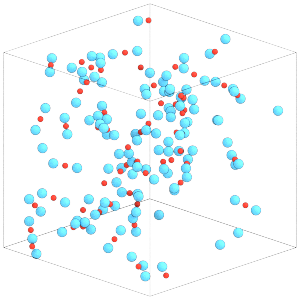

In [15]:
render(sim.state.get_snapshot())

This simulation box is dilute. Compress the box to a higher density state before continuing:

In [16]:
initial_box = sim.state.box
final_box = hoomd.Box.from_box(initial_box)  # make a copy of initial_box
final_box.volume = initial_box.volume / 16
box_resize_trigger = hoomd.trigger.Periodic(10)
ramp = hoomd.variant.Ramp(A=0, B=1, t_start=sim.timestep, t_ramp=20000)
box_resize = hoomd.update.BoxResize(box1=initial_box,
                                    box2=final_box,
                                    variant=ramp,
                                    trigger=box_resize_trigger)
sim.operations.updaters.append(box_resize)

Run the simulation to compress the box:

In [17]:
sim.run(30000)

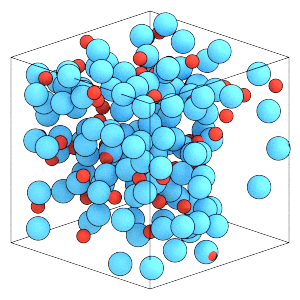

In [18]:
render(sim.state.get_snapshot())

## Thermodynamic properties of rigid bodies

Add the `ThermodynamicQuantities` compute to the simulation:

In [19]:
thermodynamic_quantities = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())

sim.operations.computes.append(thermodynamic_quantities)

`ThermodynamicQuantities` computes translational and rotational kinetic energy separately:

In [20]:
thermodynamic_quantities.translational_kinetic_energy

143.65220572221486

In [21]:
thermodynamic_quantities.rotational_kinetic_energy

89.55273500026243

These values are consistent (within exepected thermodynamic fluctuations) with the equipartition theorem:

In [22]:
translational_degrees_of_freedom = thermodynamic_quantities.translational_degrees_of_freedom
print('Translational degrees of freedom:', translational_degrees_of_freedom)
print('1/2 kT * translational degrees of freedom:', 1/2 * kT * translational_degrees_of_freedom)

Translational degrees of freedom: 189.0
1/2 kT * translational degrees of freedom: 141.75


In [23]:
rotational_degrees_of_freedom = thermodynamic_quantities.rotational_degrees_of_freedom
print('Rotataional degrees of freedom:', rotational_degrees_of_freedom)
print('1/2 kT * rotational degrees of freedom:', 1/2 * kT * rotational_degrees_of_freedom)

Rotataional degrees of freedom: 128.0
1/2 kT * rotational degrees of freedom: 96.0


Note that the number of rotational degrees is freedom is 2 times the number of particles as we
assigned 2 non-zero moments of inertia.

In this section, you learned how to continue running a simulation with rigid bodies in a GSD file,
define inter-body pairwise interactions and integrate the translational and rotational degrees of 
freedom with an integration method. The next section will explain how to prepare general rigid
bodies for HOOMD-blue.